In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read prepared B data for track-based and vertex-based tagging

In [2]:
import pandas
Bdata_tracks = pandas.read_csv('models/Bdata_tracks.csv')
Bdata_vertex = pandas.read_csv('models/Bdata_vertex.csv')

In [3]:
Bdata_tracks.head()

,Bsign,Bweight,event_id,track_relation_prob
0,1,1.091776,111761_12239990,0.980036
1,1,-0.417194,111761_16432326,2.442448
2,-1,1.044602,111761_29035939,1.442664
3,-1,1.062837,111761_30938577,0.589703
4,1,1.076036,111761_4009818,0.987601


In [4]:
Bdata_vertex.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,1,1.091776,111761_12239990,1.477121
1,1,-0.237732,111761_14379738,0.266671
2,1,-0.442830,111761_33866816,1.398243
3,-1,0.991477,111761_43041334,0.900812
4,-1,1.091055,111761_48273537,0.810535


### Merge two datasets

In [5]:
Bdata = pandas.merge(Bdata_tracks, Bdata_vertex, how='outer', on=['event_id', 'Bsign'])

In [6]:
Bdata.head()

,Bsign,Bweight_x,event_id,track_relation_prob,Bweight_y,vertex_relation_prob
0,1,1.091776,111761_12239990,0.980036,1.091776,1.477121
1,1,-0.417194,111761_16432326,2.442448,NaN,NaN
2,-1,1.044602,111761_29035939,1.442664,NaN,NaN
3,-1,1.062837,111761_30938577,0.589703,NaN,NaN
4,1,1.076036,111761_4009818,0.987601,NaN,NaN


### Obtain one weight column

In [7]:
Bdata['Bweight'] = Bdata['Bweight_x'].copy()
Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight'] = Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight_y']
Bdata = Bdata.drop(['Bweight_x', 'Bweight_y'], axis=1)

# for Nan put 1 as non influence factor
Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
Bdata.ix[numpy.isnan(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.

In [8]:
Bdata.head()

,Bsign,event_id,track_relation_prob,vertex_relation_prob,Bweight
0,1,111761_12239990,0.980036,1.477121,1.091776
1,1,111761_16432326,2.442448,1.000000,-0.417194
2,-1,111761_29035939,1.442664,1.000000,1.044602
3,-1,111761_30938577,0.589703,1.000000,1.062837
4,1,111761_4009818,0.987601,1.000000,1.076036


In [9]:
relation_prob = Bdata['track_relation_prob'].values * Bdata['vertex_relation_prob'].values
Bprob = relation_prob / (1 + relation_prob)
Bweight = Bdata.Bweight.values
Bsign = Bdata.Bsign.values

In [12]:
Bprob[~numpy.isfinite(Bprob)] = 0.5

## 2-folding calibration by isotonic

In [13]:
from utils import calibrate_probs
Bprob_calibrated = calibrate_probs(Bsign, Bweight, Bprob)

(<matplotlib.legend.Legend at 0xd90f3d0>, <matplotlib.text.Text at 0xda11bd0>)

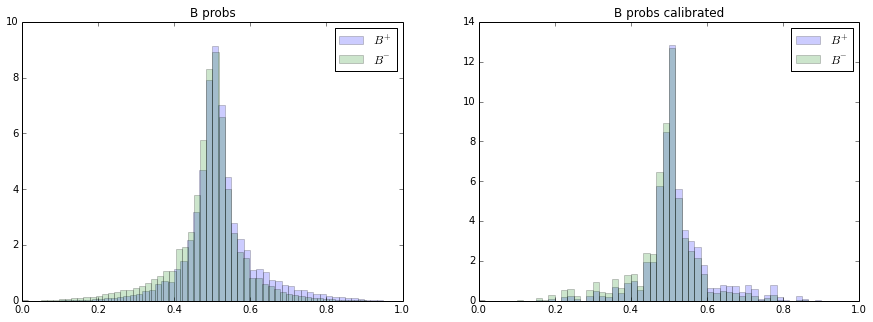

In [14]:
figure(figsize=(15, 5))

subplot(1,2,1)
hist(Bprob[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+$')
hist(Bprob[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-$')
legend(), title('B probs')

subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], bins=60, alpha=0.2, normed=True, range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], bins=60, alpha=0.2, normed=True, range=(0, 1), label='$B^-$')
legend(), title('B probs calibrated')

## AUC score and ROC curve for B+ vs B-

AUC for tagged: 0.596552661102 AUC with untag: 0.579821132444


((0, 1), (0, 1))

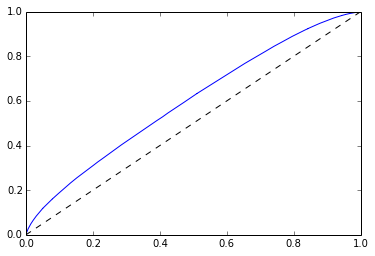

In [ ]:
from utils import calculate_auc_with_and_without_untag_events
from sklearn.metrics import roc_curve

auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

fpr, tpr, _ = roc_curve(Bsign, Bprob_calibrated, sample_weight=Bweight)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)

## D2 estimation with bootstrap calibration

In [ ]:
from utils import get_N_B_events, bootstrap_calibrate_prob, result_table

N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / get_N_B_events()

D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, 'Inclusive tagging')

AUC 0.596789644377 3.59858408695e-07


In [ ]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Inclusive tagging,77.789955,0.102331,0.034923,0.000405,2.716663,0.031715,57.982113,0


---------------------

In [19]:
prob = result_data_tracks.track_prob.values
prob = prob / (1 + prob)
tag = numpy.where(prob >= 0.5, 1, -1)
is_correct = tag * result_data_tracks.Bsign.values

In [20]:
from utils import calibrate_probs

In [21]:
p1 = calibrate_probs(result_data_tracks.Bsign.values, prob, result_data_tracks.weight)

In [22]:
p2 = calibrate_probs(tag, numpy.where(result_data_tracks.Bsign.values > 0, prob, 1-prob), result_data_tracks.weight)

In [23]:
p1_new = numpy.where(result_data_tracks.Bsign.values > 0, prob, 1-prob)

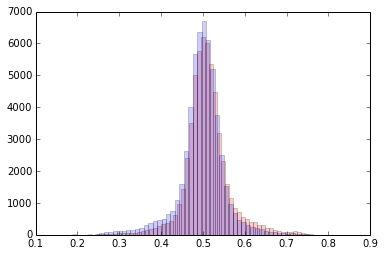

In [25]:
hist(prob[result_data_tracks.Bsign.values==1], bins=60, alpha=0.2)
hist(prob[result_data_tracks.Bsign.values==-1], bins=60, alpha=0.2)
pass

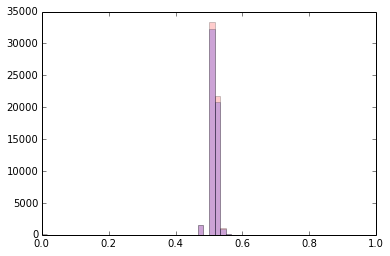

In [26]:
hist(p1[result_data_tracks.Bsign.values==1], bins=60, alpha=0.2)
hist(p1[result_data_tracks.Bsign.values==-1], bins=60, alpha=0.2)
pass

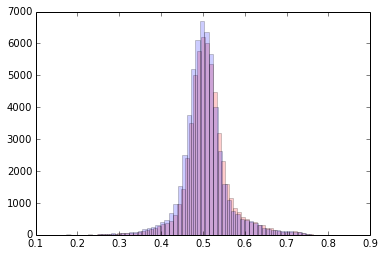

In [27]:
hist(p1_new[result_data_tracks.Bsign.values==1], bins=60, alpha=0.2)
hist(p1_new[result_data_tracks.Bsign.values==-1], bins=60, alpha=0.2)
pass